In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import pickle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, LSTM
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [6]:
data_folder = '/content/gdrive/MyDrive/University/master/term1/Machine-Learning/ML-Project/Data/'

In [7]:
# with open(data_folder + 'audio_mfcc_features_40_all_cleaned_denoised.pkl', 'rb') as file:
#     loaded_data = pickle.load(file)

# labels = []
# data = []
# for k in range(len(loaded_data)):
#     for j in range(len(loaded_data[k])):-z
#         for i in range(len(loaded_data[k][j])):
#             if np.shape(loaded_data[k][j][i]) != (1293, 40):
#                 print(k, j , i , np.shape(loaded_data[k][j][i]))
#             else:
#                 labels.append(k)
#                 data.append(loaded_data[k][j][i])
# data = np.array(data)
# labels = np.array(labels)
# np.shape(labels), np.shape(data)

In [8]:
SHAPE_SIZE = (862, 24)

In [9]:
file_name  = data_folder + "mfccaudio_chroma_features_24_all_20Sec_cleaned.pkl"
file_name_labels  = data_folder + "mfccaudio_chroma_features_24_all_20Sec_labels_cleaned.pkl"
with open(file_name, 'rb') as file:
    uncleaned_data = pickle.load(file)

with open(file_name_labels, 'rb') as file:
    uncleaned_labels = pickle.load(file)
np.shape(uncleaned_data), np.shape(uncleaned_labels)

((9538, 862, 24), (9538,))

In [10]:
np.shape(uncleaned_data[0])

(862, 24)

In [11]:
data = []
labels = []
for k, j in zip(uncleaned_data,uncleaned_labels):
    if np.shape(k) != SHAPE_SIZE:
        print(np.shape(k))
    else:
        data.append(k)
        labels.append(j)
labels = np.array(labels)
data = np.array(data)
np.shape(data), np.shape(labels)

((9538, 862, 24), (9538,))

In [12]:
np.unique(uncleaned_labels)

array([0, 1, 2, 3, 4, 5, 6])

In [13]:
labels = to_categorical(labels)
x_train, x_test, y_train, y_test =  train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=42, stratify=labels)

In [14]:
np.shape(x_train), np.shape(y_train)

((7630, 862, 24), (7630, 7))

In [15]:
class Trainer:
    def __init__(self, x_train, y_train, number_of_class=7 ,input_size=None, epochs=1000, optimizer='adam'):
        self.input_size = input_size
        self.model = Sequential()
        self.x_train, self.y_train = x_train, y_train
        self.epochs = epochs
        self.optimizer = optimizer
        self.number_of_class = number_of_class
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
    # define cnn model
    def define_model(self):
        print("Build LSTM RNN model ...")
        self.model = Sequential()

        self.model.add(LSTM(units=128, dropout=0.5, return_sequences=True, input_shape=self.input_size))
        self.model.add(LSTM(units=32,  dropout=0.5, return_sequences=False))
        self.model.add(Dense(units=self.number_of_class, activation="softmax"))
        self.model.compile(optimizer=self.optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        return self.model.summary()

    def fit_model(self):
        # fit model
        self.history = self.model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=128,
                                      validation_split=0.2, verbose=1,shuffle=True, 
                                      callbacks=[self.callback])

    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n + 1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()

    def evaluate(self, x_test, y_test):
        y_pred = np.argmax(self.model.predict(x_test), axis=-1)
        print(classification_report(np.argmax(y_test, axis=-1), y_pred, digits=3))



In [16]:
trainer = Trainer(x_train, y_train, input_size = SHAPE_SIZE, epochs=1000)
trainer.define_model()

Build LSTM RNN model ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 862, 128)          78336     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 99,175
Trainable params: 99,175
Non-trainable params: 0
_________________________________________________________________


In [17]:
trainer.fit_model()

Epoch 1/1000
48/48 [==============================] - 15s 139ms/step - loss: 1.9239 - accuracy: 0.1895 - val_loss: 1.8922 - val_accuracy: 0.2110
Epoch 2/1000
48/48 [==============================] - 6s 116ms/step - loss: 1.8860 - accuracy: 0.2302 - val_loss: 1.8728 - val_accuracy: 0.2385
Epoch 3/1000
48/48 [==============================] - 5s 112ms/step - loss: 1.8770 - accuracy: 0.2344 - val_loss: 1.8610 - val_accuracy: 0.2438
Epoch 4/1000
48/48 [==============================] - 5s 100ms/step - loss: 1.8587 - accuracy: 0.2428 - val_loss: 1.9361 - val_accuracy: 0.2359
Epoch 5/1000
48/48 [==============================] - 6s 134ms/step - loss: 1.8406 - accuracy: 0.2559 - val_loss: 1.8177 - val_accuracy: 0.2805
Epoch 6/1000
48/48 [==============================] - 5s 100ms/step - loss: 1.8281 - accuracy: 0.2742 - val_loss: 1.8234 - val_accuracy: 0.2608
Epoch 7/1000
48/48 [==============================] - 5s 98ms/step - loss: 1.8057 - accuracy: 0.2826 - val_loss: 1.8074 - val_accuracy:

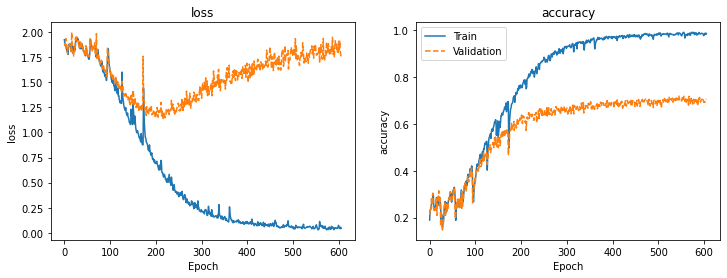

In [18]:
trainer.plot_history()

In [19]:
trainer.evaluate(x_test, y_test)

60/60 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0      0.625     0.649     0.637       251
           1      0.800     0.791     0.795       253
           2      0.686     0.619     0.651       286
           3      0.671     0.692     0.681       295
           4      0.550     0.588     0.569       243
           5      0.708     0.713     0.711       303
           6      0.826     0.805     0.815       277

    accuracy                          0.695      1908
   macro avg      0.695     0.694     0.694      1908
weighted avg      0.697     0.695     0.696      1908



In [20]:
trainer.evaluate(x_train, y_train)

239/239 [==============================] - 10s 41ms/step
              precision    recall  f1-score   support

           0      0.918     0.921     0.919      1003
           1      0.968     0.951     0.959      1011
           2      0.944     0.916     0.930      1146
           3      0.915     0.944     0.930      1181
           4      0.891     0.898     0.894       972
           5      0.926     0.945     0.935      1211
           6      0.971     0.952     0.961      1106

    accuracy                          0.933      7630
   macro avg      0.933     0.932     0.933      7630
weighted avg      0.934     0.933     0.933      7630

